# Interpretable Rating Prediction for Books: A Machine-Learning Approach

**Course:** Data Science Fundamentals

**Student:** Reema Mohammed

**Instructor:** Dr. Abdulaziz Almaleh  

**Dataset:** `data.csv`

**Target Variable:** `average rating`





====== DATA SHAPE ======

(6810, 7)

====== BASIC DATA OVERVIEW ======

            title                          authors  \
0          Gilead               Marilynne Robinson   
1    Spider's Web  Charles Osborne;Agatha Christie   
2    The One Tree             Stephen R. Donaldson   
3  Rage of angels                   Sidney Sheldon   
4  The Four Loves              Clive Staples Lewis   

                      categories  published_year  num_pages  ratings_count  \
0                        Fiction          2004.0      247.0          361.0   
1  Detective and mystery stories          2000.0      241.0         5164.0   
2               American fiction          1982.0      479.0          172.0   
3                        Fiction          1993.0      512.0        29532.0   
4                 Christian life          2002.0      170.0        33684.0   

   average_rating  
0            3.85  
1            3.83  
2            3.97  
3            3.93  
4            4.15  

====== DATA 

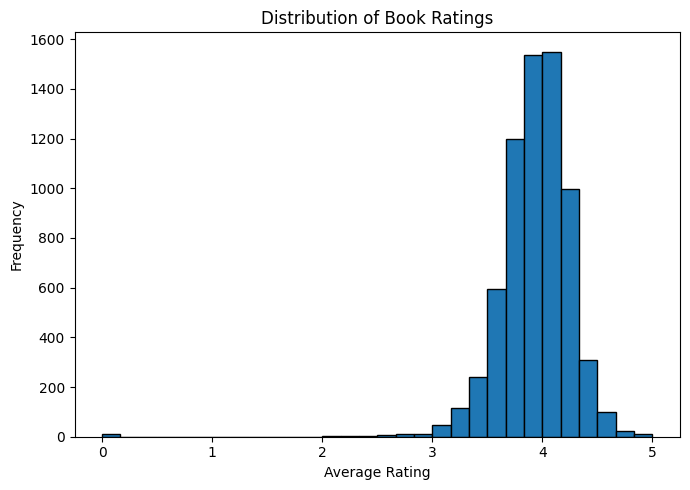

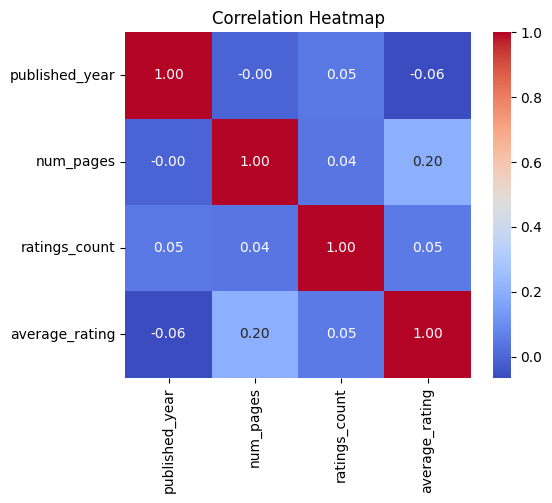

Rows initial: 6810, after duplicates removed: 0, after NA drop: 6762, after outlier filter: 6749
Train: 4049, Val: 1350, Test: 1350

Fitting GridSearchCV on training data...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params (from grid search): {'rf__max_depth': 12, 'rf__min_samples_split': 5, 'rf__n_estimators': 250}
Validation RMSE: 0.3110, R2: 0.1582, MAE: 0.2142
Test RMSE: 0.2986, R2: 0.2682, MAE: 0.2069


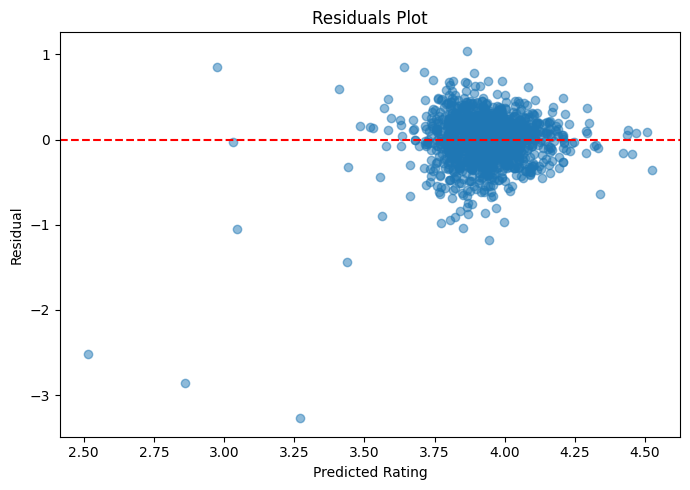

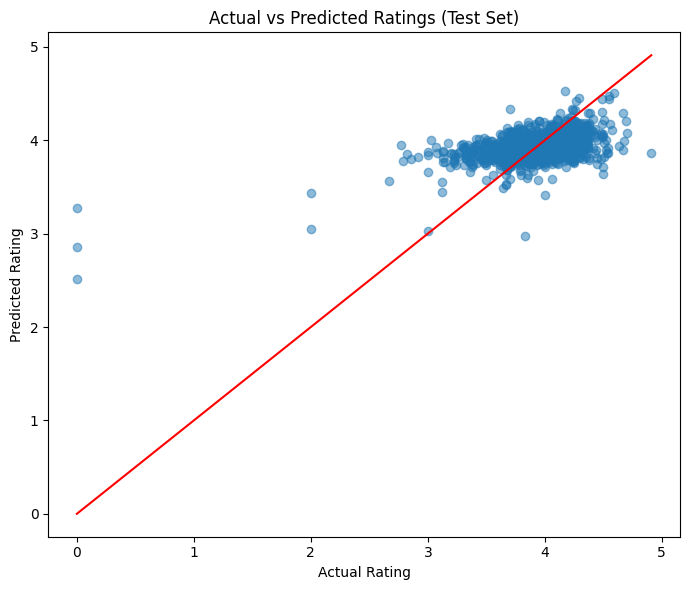


Top 20 important features:
                                     Feature  Importance
76                             ratings_count    0.311844
75                                 num_pages    0.280096
74                            published_year    0.129166
58                    categories_top_Fiction    0.057085
73                              authors_freq    0.054838
71                 categories_top_infrequent    0.016273
72                                title_freq    0.015331
67                   categories_top_Religion    0.014823
63         categories_top_Literary Criticism    0.014567
52  categories_top_Biography & Autobiography    0.012526
68                    categories_top_Science    0.010639
59                    categories_top_History    0.009273
61        categories_top_Juvenile Nonfiction    0.008432
54       categories_top_Business & Economics    0.007356
55    categories_top_Comics & Graphic Novels    0.006790
17               authors_top_Herman Melville    0.005821
66 

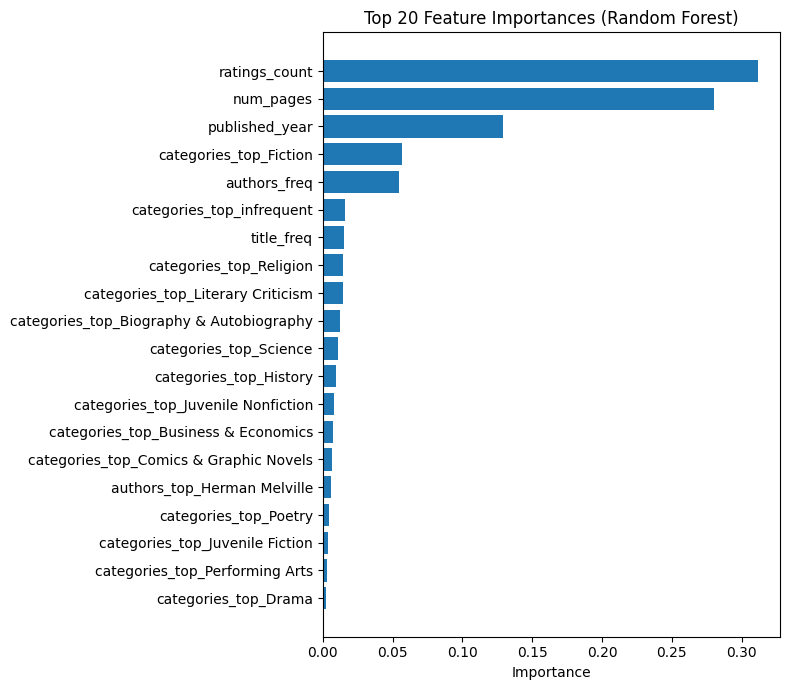

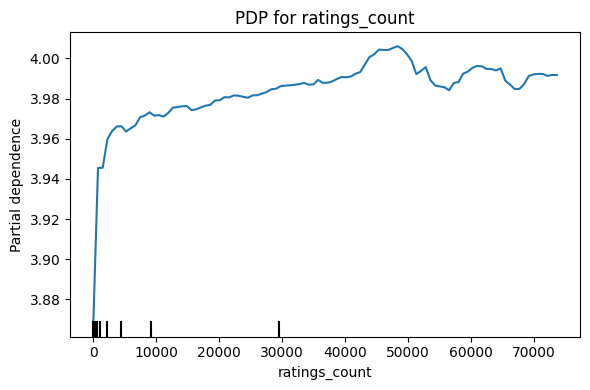

<Figure size 640x480 with 0 Axes>

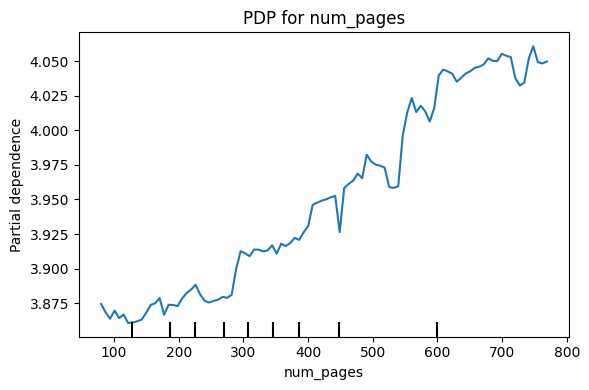

<Figure size 640x480 with 0 Axes>

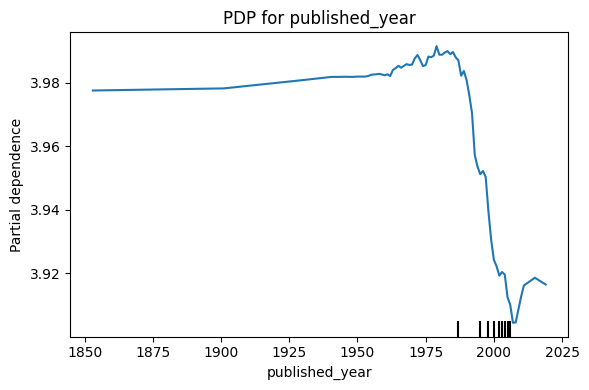

<Figure size 640x480 with 0 Axes>

In [6]:
# ============================================================
# Interpretable Rating Prediction for Books
# Full pipeline: EDA + RF model + Evaluation + Plots
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
import joblib
import os

# ---------------------------
# Constants / Reproducibility
# ---------------------------
RANDOM_STATE = 42
TOP_K_CATEGORIES = 20          # keep top-20 categories, rest -> 'infrequent'
TOP_K_AUTHORS = 50             # keep top-50 authors, rest -> 'infrequent'
MAX_PAGE = 3000                # rule-based outlier cutoff for pages
MAX_RATINGS_COUNT = 2_000_000  # rule-based cutoff for ratings_count
DATA_PATH = "data.csv"

# ---------------------------
# 1) Load data
# ---------------------------
df = pd.read_csv(DATA_PATH)

# Keep only useful columns
df = df[['title', 'authors', 'categories', 'published_year', 'num_pages',
         'ratings_count', 'average_rating']]

# ============================================================
# STEP 2: Exploratory Data Analysis (EDA)
# ============================================================

print("\n====== DATA SHAPE ======\n")
print(df.shape)

print("\n====== BASIC DATA OVERVIEW ======\n")
print(df.head())

print("\n====== DATA INFO ======\n")
print(df.info())

print("\n====== MISSING VALUES ======\n")
print(df.isnull().sum())

print("\n====== DESCRIPTIVE STATISTICS (NUMERIC) ======\n")
print(df.describe())

# 1) Histogram: Distribution of Book Ratings
plt.figure(figsize=(7,5))
plt.hist(df["average_rating"], bins=30, edgecolor='black')
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Book Ratings")
plt.tight_layout()
plt.savefig("fig_rating_distribution.png", dpi=300)
plt.show()

# 2) Correlation Heatmap for numeric features
numeric_df = df[["published_year", "num_pages", "ratings_count", "average_rating"]]
corr = numeric_df.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("fig_corr_heatmap.png", dpi=300)
plt.show()

# ---------------------------
# 2) Preprocessing: cleaning
# ---------------------------
initial_rows = df.shape[0]

# 2.a Remove exact duplicates (full-row)
df = df.drop_duplicates()
n_removed_dupes = initial_rows - df.shape[0]

# 2.b Drop rows with missing values in essential columns
df = df.dropna(subset=['published_year', 'num_pages', 'ratings_count', 'average_rating'])
n_after_dropna = df.shape[0]

# 2.c Simple rule-based outlier filtering (stabilize variance)
df = df[(df['num_pages'].between(1, MAX_PAGE)) & (df['ratings_count'] <= MAX_RATINGS_COUNT)]
n_after_outliers = df.shape[0]

print(f"Rows initial: {initial_rows}, after duplicates removed: {n_removed_dupes}, "
      f"after NA drop: {n_after_dropna}, after outlier filter: {n_after_outliers}")

# ---------------------------
# 3) Compact categorical handling (top-k + 'infrequent')
# ---------------------------
def keep_top_k(series, k, new_name):
    top = series.value_counts().nlargest(k).index
    return series.where(series.isin(top), other="infrequent").astype(str).rename(new_name)

# Apply top-k for authors and categories
df['authors_top'] = keep_top_k(df['authors'], TOP_K_AUTHORS, 'authors_top')
df['categories_top'] = keep_top_k(df['categories'], TOP_K_CATEGORIES, 'categories_top')

# Frequency encoding for title and authors
df['title_freq'] = df['title'].map(df['title'].value_counts()).astype(float)
df['authors_freq'] = df['authors'].map(df['authors'].value_counts()).astype(float)

# ---------------------------
# 4) Feature set / target
# ---------------------------
feature_cols = ['title_freq', 'authors_freq', 'authors_top', 'categories_top',
                'published_year', 'num_pages', 'ratings_count']
X = df[feature_cols].copy()
y = df['average_rating'].copy()

# ---------------------------
# 5) Train / Validation / Test split
#    - 60% train, 20% val, 20% test
# ---------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)  # 0.25 * 0.8 = 0.2

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# ---------------------------
# 6) Preprocessing pipeline
# ---------------------------
numeric_features = ['title_freq', 'authors_freq', 'published_year', 'num_pages', 'ratings_count']
categorical_features = ['authors_top', 'categories_top']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ('num', 'passthrough', numeric_features)
], remainder='drop')

# ---------------------------
# 7) Build pipeline + GridSearchCV
# ---------------------------
rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

param_grid = {
    'rf__n_estimators': [150, 250],
    'rf__max_depth': [12, 18],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_root_mean_squared_error'  # optimize RMSE
)

print("\nFitting GridSearchCV on training data...")
grid.fit(X_train, y_train)

print("Best params (from grid search):", grid.best_params_)

# ---------------------------
# 8) Validation evaluation
# ---------------------------
best_model = grid.best_estimator_
y_val_pred = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Validation RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}, MAE: {val_mae:.4f}")

# ---------------------------
# 9) Retrain on Train+Val and evaluate on Test
# ---------------------------
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)
best_model.fit(X_train_full, y_train_full)

y_test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}, MAE: {test_mae:.4f}")

# ============================================================
# Evaluation Plots (Residuals + Actual vs Predicted)
# ============================================================

# Residuals Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(7,5))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Rating")
plt.ylabel("Residual")
plt.title("Residuals Plot")
plt.tight_layout()
plt.savefig("fig_residuals.png", dpi=300)
plt.show()

# Actual vs Predicted Plot (Test Set)
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red')
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Actual vs Predicted Ratings (Test Set)")
plt.tight_layout()
plt.savefig("fig_actual_vs_predicted.png", dpi=300)
plt.show()

# ---------------------------
# 10) Feature importance (map back names)
# ---------------------------
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
numeric_names = numeric_features
all_feature_names = ohe_feature_names + numeric_names

rf_model = best_model.named_steps['rf']
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 important features:")
print(fi_df.head(20))

fi_df.to_csv("RF_feature_importance_final.csv", index=False)

# ============================================================
# Feature Importance Plot + PDPs
# ============================================================

# Top 20 Feature Importances (Bar Plot)
top20 = fi_df.sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(8,7))
plt.barh(top20["Feature"], top20["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("fig_feature_importance.png", dpi=300)
plt.show()

# Partial Dependence Plots for selected features
pdp_features = ["ratings_count", "num_pages", "published_year"]

for feat in pdp_features:
    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(best_model, X_test, [feat], ax=ax)
    ax.set_title(f"PDP for {feat}")
    plt.tight_layout()
    plt.show()
    plt.savefig(f"fig_pdp_{feat}.png", dpi=300)